# Приоритезация гипотез и A/B тестирование.
Цель: Выяснить верна гипотеза по увеличению выручки интерент-магазина.

Данные о гипотезах:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Данные заказов:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Данные визитов:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Задачи:
- Часть 1:
    Приоритизировать гипотезы с помощью методов ice и rice.
- Часть 2:
Проанализировать A/B тест.
  - Построить график кумулятивной выручки по группам
  - Построить график кумулятивного среднего чека по группам
  - Построить график относительного изменения кумулятивного среднего чека группы B к группе A
  - Построить график кумулятивной конверсии по группам
  - Построить график относительного изменения кумулятивной конверсии группы B к группе A
  - Построить точечный график количества заказов по пользователям
  - Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выберать границу для определения аномальных пользователей
  - Построить точечный график стоимостей заказов
  - Посчитать 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
  - Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным
  - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
  - Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным
  - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
  - Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth',200)

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('C:/Users/K/Desktop/datasets/hypothesis.csv')
    orders = pd.read_csv('C:/Users/K/Desktop/datasets/orders.csv')
    visitors = pd.read_csv('C:/Users/K/Desktop/datasets/visitors.csv')

display(hypothesis, hypothesis.info())
display(orders, orders.info())
display(visitors, visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


None

Вывод: таблица - hypothesis содержит наименования столбцов в верхнем регистре. Таблицы orders и visits столбцы с датами имеют тип object.

In [3]:
#Переводим названия столбцов hypothesis в нижний регистр:
hypothesis.columns = [x.lower() for x in hypothesis.columns]
display(hypothesis)

#Другие варианты:
#hypothesis.columns = map(str.lower, hypothesis.columns)
#hypothesis.columns = hypothesis.columns.str.lower()

#Приведем столбцы с датами к типу date:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
#Проверим данные в столбцах с категориями:
display(orders.groupby(['group'])['visitorId'].count())
display(visitors.groupby(['group'])['visitors'].sum())

group
A    557
B    640
Name: visitorId, dtype: int64

group
A    18736
B    18916
Name: visitors, dtype: int64

Вывод: Аномальных значений в группах обоих таблиц нет, данные по граппам распределены приемлемо.

In [5]:
# Проверим есть ли пользователи, которые одновременно находятся в двух группах

# Разделим заказы на две группы:
group_a = orders[orders['group']=='A']
group_b = orders[orders['group']=='B']

# Найдем пользователей, которые присутствуют в обоих группах одновременно:
merge_group = pd.merge(group_a, group_b, on='visitorId', suffixes=['_A','_B'])

# Создаем список уникальных пользователей:
a_and_b_users = merge_group['visitorId'].unique()
display(len(a_and_b_users))
display(orders['visitorId'].nunique())

# Удалим пользователей из таблицы заказов:
orders = orders[~orders['visitorId'].isin(a_and_b_users)]
display(orders)
display(orders['visitorId'].nunique())

# 2-й способ формирования списка пользователей состоящих в двух группах:
#order2 = orders_.groupby('visitorId')['group'].apply(lambda x: x.unique()).reset_index()
#order2['len'] = order2['group'].str.join(',').str.len()
#order2 = order2[order2['len']>1]
#display(order2['visitorId'].unique())

58

1031

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


973

Вывод: Количество пользователей, которые состоят одновременно в обоих группах - 58, заказы этих пользователей удалены из таблицы заказов - 1031-58=973.

# Приоритизация гипотез.

In [7]:
#Приоритизируем гипотезы с помощью фреймворка ICE по формуле: (ICE = (impact*confidence)/efforts).
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis.sort_values(by='ice', ascending=False, inplace=True)
hypothesis['ice_position'] = range(1, len(hypothesis)+1)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ice,ice_position
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,1
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,2
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,7
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,9


In [8]:
#Приоритизируем гипотезы с помощью фреймворка RICE по формуле: (RICE = (reach*impact*confidence)/efforts
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis.sort_values(by='rice', ascending=False, inplace = True)
hypothesis['rice_position'] = range(1, len(hypothesis)+1)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ice,ice_position,rice,rice_position
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,3,112.0,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,5,56.0,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,2,40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,4,40.0,4
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,1,16.2,5
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,8,9.0,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,6,4.0,7
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,7,4.0,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,9,3.0,9


Вывод: в столбце - ice_position - указана позиция гипотезы по методу ice. Если сравнить позиции гипотез по двум методам ice и rice, то наблюдается, большое не соответствие приоритетов гипотез в зависимости от метода приоритезации. В случае ice метода большую роль играет - confidence(уверенность в оценках других параметров гипотезы - охват, влияние, трудозатраты на внедрение). А в случае rice метода - reah(охват). В обоих случаях наблюдается прямая зависимость между позицией гипотезы в приоритете от соответствующих параметров confidence для ice и reach для rice.

Приоритет гипотез: Если выбрать три самые приоритетные гипотезы, то выбрать нужно следующие
гипотезы в порядке приоритета:


- 1 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (позиции ice 3, rice	1)
- 2 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (позиции ice 2, rice	3)
- 3 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве.. (позиции ice 4, rice	4)
    
Так же приоритеты зависят от того, какой фреймворк нам важнее на данный момент

# Анализ A/B - теста.

In [9]:
# Проверка групп для AB теста:

# Посмотрим на распределение заказов и визитов по группам:
display(orders.groupby('group').agg({'transactionId':'count'}))
display(visitors.groupby('group').agg({'visitors':'sum'}))

,transactionId
group,
A,468
B,548


,visitors
group,
A,18736
B,18916


Группы по заказами и визитам распределены не по ровну, повод написать рекомендацию составителю данных тщательнее проверять состав групп.

## 1 Построим график кумулятивной выручки по группам.

In [10]:
#Создаем таблицу с уникальнвми парами (дата - группа), она понадобиться для вычисления "максимальных" значений дат и групп.
dates_groups = orders[['date','group']].drop_duplicates()

#Рассчитаем куммулятивные данные по выручке:
order_agg = dates_groups.apply(lambda x: 
                                 orders[np.logical_and(orders['date']<x['date'], orders['group']==x['group'])]
                                .agg({'transactionId':'nunique','visitorId':'nunique','date':'max','revenue':'sum','group':'max'}), axis=1).sort_values(by=['date','group'])

#Рассчитаем куммулятивные данные по посещению:
visit_agg = dates_groups.apply(lambda x:
                               visitors[np.logical_and(visitors['date']<x['date'], visitors['group']==x['group'])]
                               .agg({'date':'max','group':'max','visitors':'sum'}),axis=1).sort_values(by=['date','group'])

display(order_agg.head(2))
display(visit_agg.head(2))

,transactionId,visitorId,date,revenue,group
175,23,19,2019-08-01,142779,A
173,17,17,2019-08-01,59758,B


,date,group,visitors
175,2019-08-01,A,719
173,2019-08-01,B,713


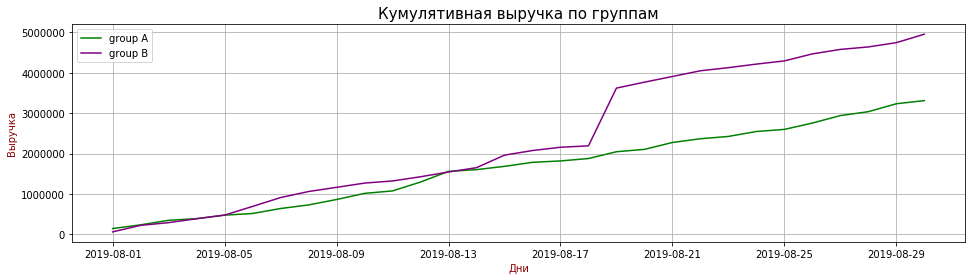

In [11]:
#Объединим куммулятивные данные по двум таблицам - ord_agg и visit_agg:
cum_data = order_agg.merge(visit_agg, left_on=['date', 'group'], right_on=['date','group'])

#Переименуем стобцы:
cum_data = cum_data.rename(columns={'revenue':'total_revenue','transactionId':'total_orders'})

#Создаем таблицу с куммулятивной выручкой по группе А:
cum_revenue_a = cum_data[cum_data['group']=='A'][['date','total_revenue','total_orders']]

#Создаем таблицу с куммулятивной выручкой по группе B:
cum_revenue_b = cum_data[cum_data['group']=='B'][['date','total_revenue','total_orders']]

#Построим графики по группам:
plt.figure(figsize=(16,4))
plt.grid(True)
plt.title("Кумулятивная выручка по группам", fontsize=15)
plt.xlabel('Дни', fontdict={'color':'darkred'})
plt.ylabel('Выручка', fontdict={'color':'darkred'})
plt.plot(cum_revenue_a['date'], cum_revenue_a['total_revenue'], label='group A', color='green')
plt.plot(cum_revenue_b['date'], cum_revenue_b['total_revenue'], label='group B', color='purple')
plt.legend()
plt.show()

Вывод: Revenue равномерно растет на всем временном отрезке, в группе B - куммулятивная выручка резко возрастает на 2019-08-18. Это может быть связанно с увеличением числа заказов или с заказами высокой стоимости.

## 2 Построим график кумулятивного среднего чека по группам.

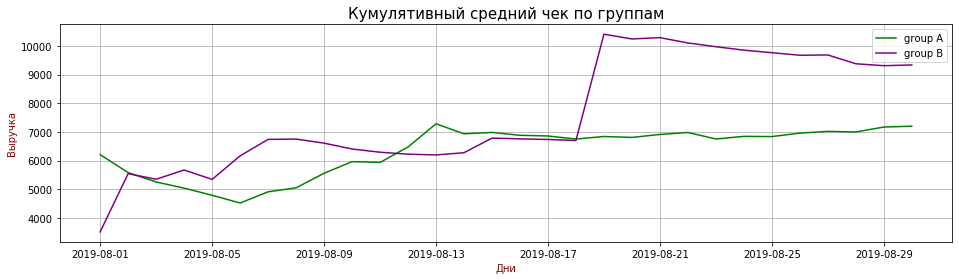

In [12]:
# Построим график:
plt.figure(figsize=(16,4))
plt.grid(True)
plt.title("Кумулятивный средний чек по группам", fontsize=15)
plt.xlabel('Дни', fontdict={'color':'darkred'})
plt.ylabel('Выручка', fontdict={'color':'darkred'})
plt.plot(cum_revenue_a['date'], cum_revenue_a['total_revenue']/cum_revenue_a['total_orders'], label='group A', color='green')
plt.plot(cum_revenue_b['date'], cum_revenue_b['total_revenue']/cum_revenue_b['total_orders'], label='group B', color='purple')
plt.legend()
plt.show()

Вывод: Куммулятивный средний чек на графике не стабилен до 2019-08-17 для двух групп, после чего в группе B значение резко возрастает, далее значения по группам начинают сближаться.

## 3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

,date,total_revenue_A,total_orders_A,total_revenue_B,total_orders_B
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40


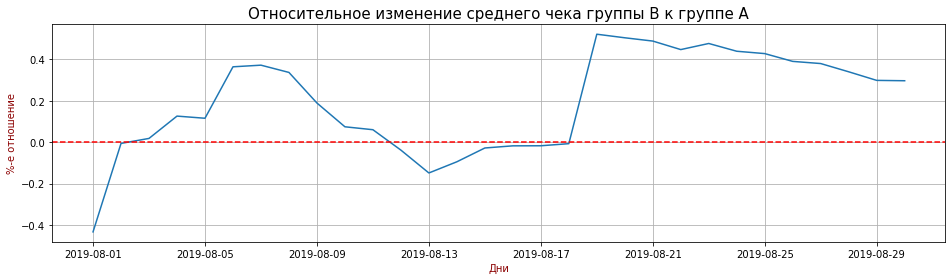

In [13]:
#Соединим данные по двум группам:
merge_cum_revenue=pd.merge(cum_revenue_a, cum_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_A','_B'])
display(merge_cum_revenue.head(2))

#Построим график относительного изменения куммулятивного среднего чека группы B к группе A:
plt.figure(figsize=(16,4))
plt.grid(True)
plt.title("Относительное изменение среднего чека группы B к группе A", fontsize=15)
plt.xlabel('Дни', fontdict={'color':'darkred'})
plt.ylabel('%-е отношение', fontdict={'color':'darkred'})
plt.plot(merge_cum_revenue['date'], (merge_cum_revenue['total_revenue_B']/merge_cum_revenue['total_orders_B'])/
         (merge_cum_revenue['total_revenue_A']/merge_cum_revenue['total_orders_A'])-1)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

Вывод: отношение куммулятивного среднего чека группы B к группе A не стабильны и так же резко изменяется на дату - 2019-08-18,  видимо присутствуют аномальные заказы в этот день. Далее идет плавное снижение относительного изменения среднего чека по группам.

## 4 Построим график кумулятивной конверсии по группам:

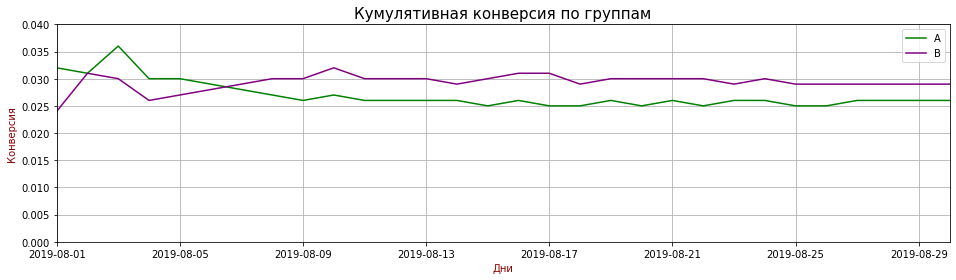

,total_orders,visitorId,date,total_revenue,group,visitors,conversion
0,23,19,2019-08-01,142779,A,719,0.032
1,17,17,2019-08-01,59758,B,713,0.024


In [14]:
# Расчитаем конверсию по группам:
cum_data['conversion'] = round(cum_data['total_orders'] / cum_data['visitors'], 3)

#Разделим данные кумулятивной конверсии на группы A и B:
cum_data_conv_a = cum_data[cum_data['group'] == 'A']
cum_data_conv_b = cum_data[cum_data['group'] == 'B']

#Построим график:
plt.figure(figsize=(16,4))
plt.grid(True)
plt.title("Кумулятивная конверсия по группам", fontsize=15)
plt.xlabel('Дни', fontdict={'color':'darkred'})
plt.ylabel('Конверсия', fontdict={'color':'darkred'})

plt.plot(cum_data_conv_a['date'], cum_data_conv_a['conversion'], label='A', color='green')
plt.plot(cum_data_conv_b['date'], cum_data_conv_b['conversion'], label='B', color='purple')
plt.legend()
plt.axis(["2019-08-01", '2019-08-30', 0, 0.04]) 
plt.show()
display(cum_data.head(2))

Вывод: кумулятивная конверсия обоих групп немного колеблется в начале месяца, но уже 6-й день конверсия группы B становится выше и обе конверсии идут параллельно друг другу.

## 5 Построим график относительного изменения кумулятивной конверсии группы B к группе A.

['2019-08-01', '2019-08-30', -0.3, 0.3]

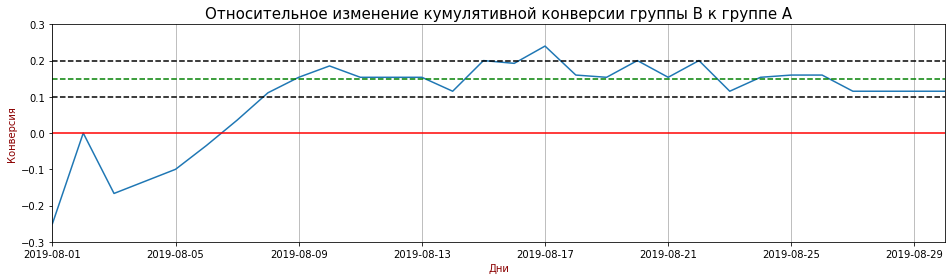

In [15]:
# 
a_b_conversion = cum_data_conv_a[['date','conversion']].merge(cum_data_conv_b[['date','conversion']], on='date', suffixes=['_A','_B'])

plt.figure(figsize=(16,4))
plt.grid(True, axis='x')
plt.title("Относительное изменение кумулятивной конверсии группы B к группе A", fontsize=15)
plt.xlabel('Дни', fontdict={'color':'darkred'})
plt.ylabel('Конверсия', fontdict={'color':'darkred'})
plt.plot(a_b_conversion['date'], a_b_conversion['conversion_B'] / a_b_conversion['conversion_A'] - 1, label='fghj')
plt.axhline(y=0, color='red', linestyle='-')
plt.axhline(y=0.2, color='black', linestyle='--')
plt.axhline(y=0.15, color='green', linestyle='--')
plt.axhline(y=0.1, color='black', linestyle='--')

plt.axis(["2019-08-01", '2019-08-30', -0.3, 0.3])

Вывод: конверсия группы B на 6-й день теста становится выше группы A, затем достигает значения в 20%, и колеблется между 10% и 20%.

# 6 Построим точечный график количества заказов по пользователям.

,transactionId
visitorId,
3967698036,3
249864742,3
2108163459,3
2988190573,3
3908431265,3
611059232,3
2742574263,3
678354126,2


array([1., 2.])

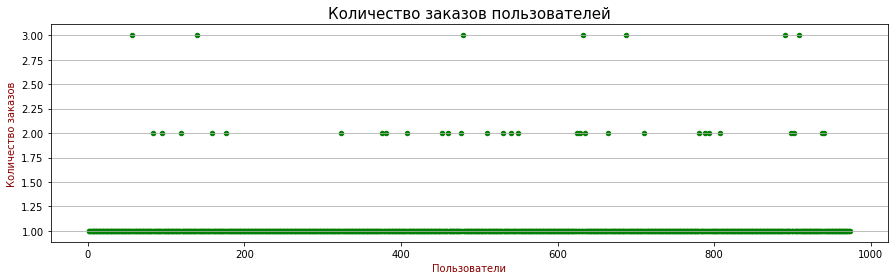

In [16]:
orders_per_users = orders.groupby('visitorId').agg({'transactionId':'count'})
display(orders_per_users.sort_values('transactionId', ascending=False).head(8))

x = range(1, len(orders_per_users)+1)

plt.figure(figsize=(15,4))
plt.grid(True, axis='y')
plt.title("Количество заказов пользователей", fontsize=15)
plt.xlabel('Пользователи', fontdict={'color':'darkred'})
plt.ylabel('Количество заказов', fontdict={'color':'darkred'})
plt.scatter(x, orders_per_users['transactionId'], color='green', s=20)

# Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей:
display(np.percentile(orders_per_users['transactionId'],[95,99]))

Вывод: Не более 5% пользователей заказали 2 и более заказов и 1% пользователей сделали 3 заказа. Для дальнейшего расчета стат. значимостей возьмем пользователей которые сделали максимум 2 заказа.

## 7 Построим точечный график стоимостей заказов.

array([26785., 53904.])

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


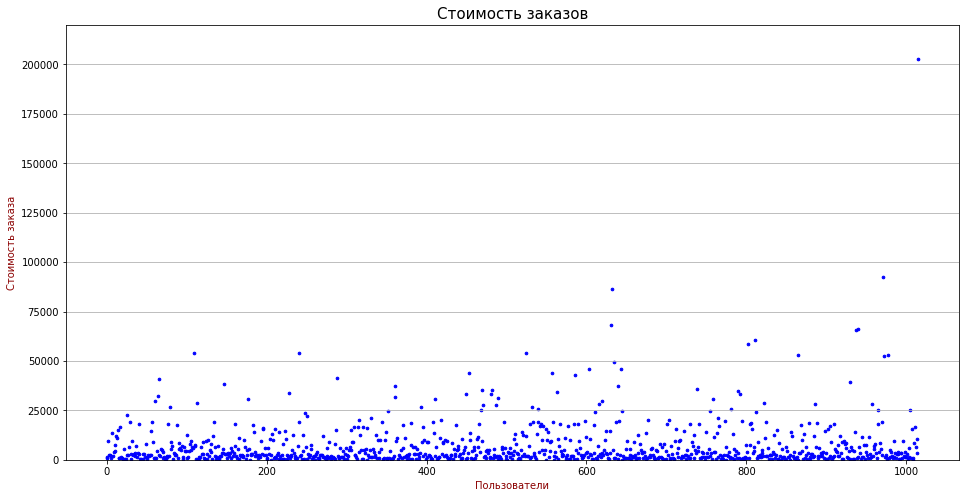

In [17]:
x = range(0, len(orders))
plt.figure(figsize=(16,8))
plt.grid(True, axis='y')
plt.title("Стоимость заказов", fontsize=15)
plt.xlabel('Пользователи', fontdict={'color':'darkred'})
plt.ylabel('Стоимость заказа', fontdict={'color':'darkred'})
plt.ylim(0,220000)
plt.scatter(x, orders['revenue'], c = 'blue', s=7)

# Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов:
display(np.percentile(orders['revenue'],[95,99]))

display(orders.sort_values(by='revenue', ascending=False).head(2))

Вывод: не более 5% пользователей сделали заказ на сумму более 26785, и не более 1% пользователей сделали заказ на сумму более - 53904. Для дальнейшего расчета стат. значимостей возьмем пользователей которые сделали заказы стоимостью не более чемм в - 26785.

Дополнительно: Рассмотрим аномальные заказы когда они сделаны и на какую сумму.

In [18]:
display("Заказы стоимостью выше 100 000:", orders[orders['revenue'] > 100000])

'Заказы стоимостью выше 100 000:'

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


Вывод: всего 2 заказа стоимостью выше 100 000.

## Подготовим данные для проверки гипотез:

In [19]:
# Переименуем названия столбцов:
orders.columns = ['order_id','user_id', 'date','revenue','group']

# Посчитаем количество посетителей группы A по дням:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date','visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

# Посчитаем кумулятивное количество пользователей группы A по дням:
cum_visitors_a = visitors_daily_a.apply(lambda x: visitors_daily_a[visitors_daily_a['date']<=x['date']]
                                        .agg({'date':'max','visitors_per_date_a':'sum'}), axis=1)
cum_visitors_a.columns = ['date','cumulative_visitors_a']

display(visitors_daily_a.head(2))
display(cum_visitors_a.head(2))

,date,visitors_per_date_a
0,2019-08-01,719
1,2019-08-02,619


,date,cumulative_visitors_a
0,2019-08-01,719
1,2019-08-02,1338


In [20]:
# Посчитаем количество посетителей группы B по дням:
visitors_daily_b = visitors[visitors['group'] == 'B'][['date','visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

# Посчитаем кумулятивное количество пользователей группы B по дням:
cum_visitors_b = visitors_daily_b.apply(lambda x: visitors_daily_b[visitors_daily_b['date']<=x['date']]
                                        .agg({'date':'max','visitors_per_date_b':'sum'}), axis=1)
cum_visitors_b.columns = ['date','cumulative_visitors_b']

display(visitors_daily_b.head(2))
display(cum_visitors_b.head(2))

,date,visitors_per_date_b
31,2019-08-01,713
32,2019-08-02,581


,date,cumulative_visitors_b
31,2019-08-01,713
32,2019-08-02,1294


In [21]:
#Посчитаем количество заказов, и выручку по дням группы A:
orders_daily_a = (orders[orders['group'] == 'A'][['date', 'order_id','user_id','revenue']]
                 .groupby('date', as_index=False)
                 .agg({'order_id':'nunique', 'revenue':'sum'}))
orders_daily_a.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

#Посчитаем кумулятивные значения количества заказов и сумму выручки по дням:
cum_orders_a = orders_daily_a.apply(lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']]
                                    .agg({'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}), axis=1).sort_values(by=['date'])
cum_orders_a.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

display(orders_daily_a.head(2))
display(cum_orders_a.head(2))

,date,orders_per_date_a,revenue_per_date_a
0,2019-08-01,23,142779
1,2019-08-02,19,91602


,date,orders_cummulative_a,revenue_cummulative_a
0,2019-08-01,23,142779
1,2019-08-02,42,234381


In [22]:
#Посчитаем количество заказов, и выручку по дням группы B:
orders_daily_b = (orders[orders['group'] == 'B'][['date', 'order_id','user_id','revenue']]
                 .groupby('date', as_index=False)
                 .agg({'order_id':'nunique', 'revenue':'sum'}))
orders_daily_b.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

#Посчитаем кумулятивные значения количества заказов и сумму выручки по дням:
cum_orders_b = orders_daily_b.apply(lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']]
                                    .agg({'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}), axis=1).sort_values(by=['date'])
cum_orders_b.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

display(orders_daily_b.head(2))
display(cum_orders_b.head(2))

,date,orders_per_date_b,revenue_per_date_b
0,2019-08-01,17,59758
1,2019-08-02,23,162043


,date,orders_cummulative_b,revenue_cummulative_b
0,2019-08-01,17,59758
1,2019-08-02,40,221801


In [23]:
#Соединим полученные таблицы:
data = (orders_daily_a
        .merge(orders_daily_b, left_on = 'date', right_on = 'date', how = 'left')
        .merge(cum_orders_a, left_on = 'date', right_on = 'date', how = 'left')
        .merge(cum_orders_b, left_on = 'date', right_on = 'date', how = 'left')
        .merge(visitors_daily_a, left_on = 'date', right_on = 'date', how = 'left')
        .merge(visitors_daily_b, left_on = 'date', right_on = 'date', how = 'left')
        .merge(cum_visitors_a, left_on = 'date', right_on = 'date', how = 'left')
        .merge(cum_visitors_b, left_on = 'date', right_on = 'date', how = 'left'))
        
display(data.head(2))

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,cumulative_visitors_a,cumulative_visitors_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294


In [24]:
# Посчитаем количество заказов каждого пользователя в группе A:
order_by_user_a = orders[orders['group'] == 'A'].groupby('user_id', as_index=False).agg({'order_id':'count'})
order_by_user_a.columns = ['user_id', 'orders']

# Посчитаем количество заказов каждого пользователя в группе B:
order_by_user_b = orders[orders['group'] == 'B'].groupby('user_id', as_index=False).agg({'order_id':'count'})
order_by_user_b.columns = ['user_id', 'orders']

display(order_by_user_a.sort_values(by='orders',ascending=False).head(2))
display(order_by_user_b.sort_values(by='orders',ascending=False).head(2))

,user_id,orders
58,611059232,3
211,2108163459,3


,user_id,orders
347,2742574263,3
33,249864742,3


## 8 Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [25]:
#Подготовим данные для групп A и B:
#(В каждой группе соединим количество заказов каждого пользователя(которые сделали заказ) с данными остальных посетителей,
#(которые не сделали заказ - количество заказов - 0).
sample_a = pd.concat([order_by_user_a['orders'], pd.Series(0,index=np.arange(data['visitors_per_date_a'].sum()
                                                                           -len(order_by_user_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([order_by_user_b['orders'], pd.Series(0,index=np.arange(data['visitors_per_date_b'].sum()
                                                                           -len(order_by_user_b['orders'])), name='orders')],axis=0)


display("{0:.5f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

# Рассчитаем относительный прирост конверсии группы B к группе A 
display("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

'0.00551'

'0.160'

Сформулируем гипотезы:
    
- Нулева гипотеза: конверсии группы A и группы B равны.
- Альтернативная гипотеза: конверсии группы A и группы B различаются.
    
Значение p_value = 0.0055 меньше 0.05, т.е. нулевую гипотезу отвергаем, значит в конверсии между группами есть статистически значимые различия. Статистическая значимость достигнута. И относительный прирост конверсии группы B к группе A равен 16%.

## 9 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [26]:
display('{0:.4f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

# Рассчитаем относительное различие среднего чека между группами: 
display('{0:.4f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

'0.4147'

'0.2866'

Сформулируем гипотезы:
    
- Нулева гипотеза: значения среднего чека группы A и группы B равны.
- Альтернативная гипотеза: значения среднего чека группы A и группы B различаются.    
    
Значение  p_value = 0.414 больше 0.05, нулевую гипотезу не отвергаем. Статистически значимых отличий в среднем чеке между группами нет, однако относительное различие среднего чека между группами 28%, разница случайна.

## 10 Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [27]:
# Найдем пользователей с большим количеством заказов:
much_orders_users = pd.concat([order_by_user_a[order_by_user_a['orders'] > 2]['user_id'],
                               order_by_user_b[order_by_user_b['orders'] > 2]['user_id']], axis = 0)

# Найдем пользователей с дорогими заказами:
expensive_orders_users = orders[orders['revenue']>26785]['user_id']

# Объединим пользователей с большим количеством заказо и с высокой стоимостью заказов:
unomaly_users = pd.concat([much_orders_users, expensive_orders_users], axis=0).drop_duplicates()


display("Аномальных пользователей: " + str(unomaly_users.count()))

# Создадим группы пользователей по очищенным данным:
clear_sample_a = pd.concat([order_by_user_a[np.logical_not(order_by_user_a['user_id'].isin(unomaly_users))]
                ['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum()
                                                         -len(order_by_user_a['orders'])), name='orders')], axis=0)

clear_sample_b = pd.concat([order_by_user_b[np.logical_not(order_by_user_b['user_id'].isin(unomaly_users))]
                ['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum()
                                                         -len(order_by_user_b['orders'])), name='orders')], axis=0)

display('{0:.3f}'.format(st.mannwhitneyu(clear_sample_a, clear_sample_b)[1]))

# Рассчитаем относительный прирост конверсии группы B к группе A:
display('{0:.3f}'.format(clear_sample_b.mean()/clear_sample_a.mean()-1))

'Аномальных пользователей: 58'

'0.006'

'0.182'

Сформулируем гипотезы:

- Нулева гипотеза: конверсии группы A и группы B равны.
- Альтернативная гипотеза: конверсии группы A и группы B различаются.   
    
Значение p_value = 0.006 меньше 0.05, т.е. нулевую гипотезу отвергаем, значит в конверсии между группами есть статистически значимые различия. Статистическая значимость достигнута. Группа B лучше группы A, и относительный прирост конверсии группы B к группе A равен 18%.

## 11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [28]:
print('{0:.3f}'.format(st
                       .mannwhitneyu(orders[np.logical_and(orders['group'] == 'A'
                                                           ,np.logical_not(orders['user_id'].isin(unomaly_users)))]['revenue']
                                     ,orders[np.logical_and(orders['group'] == 'B'
                                                            ,np.logical_not(orders['user_id'].isin(unomaly_users)))]['revenue'])[1]))

# Рассчитаем относительное различие среднего чека между группами:
print("{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B'
                                             , np.logical_not(orders['user_id'].isin(unomaly_users)),)]['revenue'].mean()
                       / orders[np.logical_and(orders['group'] == 'A'
                                               ,np.logical_not(orders['user_id'].isin(unomaly_users)),)]['revenue'].mean() - 1))

0.323
-0.048


Сформулируем гипотезы:
    
- Нулева гипотеза: значения среднего чека группы A и группы B равны.
- Альтернативная гипотеза: значения среднего чека группы A и группы B различаются.    

Значение p_value = 0.323 больше 0.05, нулевую гипотезу не отвергаем. Статистически значимых отличий в среднем чеке между группами нет, относительное различие среднего чека между группами -0.048%, разница случайна.

## 14 Принять решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Общий вывод:
    
- Тест длился 30 дней. Количество заказов группы A - 468, группы B - 548.
- Кумулятивный средний чек не стабилен в чачале теста, резкий скачак на графиках до с 2019-08-18 по до 2019-08-19 обусловлен аномальным заказом (transactionId - 590470918,	visitorId-1920142716,	2019-08-19, сумма 1294500,	группа - B).
- Кумулятивная конверсия на графиках группы B выше чем у группы A в среднем на 15%.
- В основном покупатели делают 1-2 заказа, стоимость большей части которых до 25000.
- Разница в конверсии групп имеет статистическую значимость как с "сырыми данными", так и с очищенными, т.е. нулевую гипотезу отвергаем. Относительный прирост конверсии группы B к группе A составил 18%. По очищенным данным вероятность того, что разница окажется случайной составит - 0,6%(p_value = 0.006). 
- Разница с среднем чеке групп статистической значимости не имеет, как с "сырыми данными" так и с очищенными, т.е. нулевую гипотезу не отвергаем. По очищенным данным вероятность того, что разница будет случайной составит 32,3%(p_value = 0.323).
- Тест остановить, различие в значении конверсии групп установленна, различие в средних чеках групп установить не удалось.
- Рекомендация - проверить разбивку клиентов на группы.